# **Analyse des Données de Restaurant**
***
## **Introduction et Préparation des Données**

### **Importation des bibliothèques nécessaires**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import warnings

# Configuration pour afficher tous les colonnes
pd.set_option('display.max_columns', None)
# Configuration pour de meilleurs graphiques
sns.set_palette("deep")

### **Chargement des données**

In [2]:
menu_items = pd.read_csv('Data/menu_items.csv')
order_details = pd.read_csv('Data/order_details.csv')

### **Exploration initiale des données**

In [3]:
print(menu_items.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   menu_item_id  32 non-null     int64  
 1   item_name     32 non-null     object 
 2   category      32 non-null     object 
 3   price         32 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 1.1+ KB
None


In [4]:
menu_items.head()

,menu_item_id,item_name,category,price
0,101,Hamburger,American,12.95
1,102,Cheeseburger,American,13.95
2,103,Hot Dog,American,9.00
3,104,Veggie Burger,American,10.50
4,105,Mac & Cheese,American,7.00


In [5]:
print(order_details.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12234 entries, 0 to 12233
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   order_details_id  12234 non-null  int64  
 1   order_id          12234 non-null  int64  
 2   order_date        12234 non-null  object 
 3   order_time        12234 non-null  object 
 4   item_id           12097 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 478.0+ KB
None


In [6]:
order_details.head()

,order_details_id,order_id,order_date,order_time,item_id
0,1,1,1/1/23,11:38:36 AM,109.0
1,2,2,1/1/23,11:57:40 AM,108.0
2,3,2,1/1/23,11:57:40 AM,124.0
3,4,2,1/1/23,11:57:40 AM,117.0
4,5,2,1/1/23,11:57:40 AM,129.0


### **Nettoyage et préparation des données**

In [7]:
# Conversion des colonnes de date et d'heure en un seul objet datetime
order_details['order_datetime'] = pd.to_datetime(order_details['order_date'] + ' ' + order_details['order_time'])

C:\Users\DIALO\AppData\Local\Temp\ipykernel_15120\111630611.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  order_details['order_datetime'] = pd.to_datetime(order_details['order_date'] + ' ' + order_details['order_time'])


In [8]:
# Fusion des données de commande avec les informations de menu
orders_with_details = pd.merge(order_details, menu_items, left_on='item_id', right_on='menu_item_id')

In [9]:
print("\nAperçu des données fusionnées :")
print(orders_with_details.info())


Aperçu des données fusionnées :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12097 entries, 0 to 12096
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   order_details_id  12097 non-null  int64         
 1   order_id          12097 non-null  int64         
 2   order_date        12097 non-null  object        
 3   order_time        12097 non-null  object        
 4   item_id           12097 non-null  float64       
 5   order_datetime    12097 non-null  datetime64[ns]
 6   menu_item_id      12097 non-null  int64         
 7   item_name         12097 non-null  object        
 8   category          12097 non-null  object        
 9   price             12097 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 945.2+ KB
None


In [10]:
print("\nLes 5 premières lignes des données fusionnées :")
orders_with_details.head()


Les 5 premières lignes des données fusionnées :


,order_details_id,order_id,order_date,order_time,item_id,order_datetime,menu_item_id,item_name,category,price
0,1,1,1/1/23,11:38:36 AM,109.0,2023-01-01 11:38:36,109,Korean Beef Bowl,Asian,17.95
1,2,2,1/1/23,11:57:40 AM,108.0,2023-01-01 11:57:40,108,Tofu Pad Thai,Asian,14.50
2,3,2,1/1/23,11:57:40 AM,124.0,2023-01-01 11:57:40,124,Spaghetti,Italian,14.50
3,4,2,1/1/23,11:57:40 AM,117.0,2023-01-01 11:57:40,117,Chicken Burrito,Mexican,12.95
4,5,2,1/1/23,11:57:40 AM,129.0,2023-01-01 11:57:40,129,Mushroom Ravioli,Italian,15.50


In [11]:
# Vérification des valeurs manquantes
print("\nVérification des valeurs manquantes :")
orders_with_details.isnull().sum()


Vérification des valeurs manquantes :


order_details_id    0
order_id            0
order_date          0
order_time          0
item_id             0
order_datetime      0
menu_item_id        0
item_name           0
category            0
price               0
dtype: int64

In [12]:
# Statistiques descriptives
print("\nStatistiques descriptives des données numériques(variable price) :")
orders_with_details.describe()['price']


Statistiques descriptives des données numériques(variable price) :


count    12097.000000
mean        13.161767
min          5.000000
25%         10.500000
50%         13.950000
75%         16.500000
max         19.950000
std          3.986392
Name: price, dtype: float64

In [13]:
# Vérification des doublons
duplicates = orders_with_details.duplicated().sum()
print(f"\nNombre de lignes dupliquées : {duplicates}")


Nombre de lignes dupliquées : 0


In [14]:
# Création de nouvelles caractéristiques utiles pour l'analyse
orders_with_details['day_of_week'] = orders_with_details['order_datetime'].dt.dayofweek
orders_with_details['hour'] = orders_with_details['order_datetime'].dt.hour
orders_with_details['month'] = orders_with_details['order_datetime'].dt.month


In [15]:
print("\nAperçu des nouvelles caractéristiques ajoutées :")
orders_with_details[['order_datetime', 'day_of_week', 'hour', 'month']].head()


Aperçu des nouvelles caractéristiques ajoutées :


,order_datetime,day_of_week,hour,month
0,2023-01-01 11:38:36,6,11,1
1,2023-01-01 11:57:40,6,11,1
2,2023-01-01 11:57:40,6,11,1
3,2023-01-01 11:57:40,6,11,1
4,2023-01-01 11:57:40,6,11,1


In [16]:
# Sauvegarde des données préparées (optionnel)
orders_with_details.to_csv('prepared_restaurant_data.csv', index=False)

print("\nPréparation des données terminée. Les données sont prêtes pour l'analyse exploratoire.")


Préparation des données terminée. Les données sont prêtes pour l'analyse exploratoire.


## **Analyse des articles de menu**

In [17]:
# Articles les plus et moins commandés
item_counts = orders_with_details['item_name'].value_counts()
print("\nArticles les plus commandés :")
print(item_counts.head())
print("\nArticles les moins commandés :")
print(item_counts.tail())


Articles les plus commandés :
item_name
Hamburger           622
Edamame             620
Korean Beef Bowl    588
Cheeseburger        583
French Fries        571
Name: count, dtype: int64

Articles les moins commandés :
item_name
Cheese Quesadillas    233
Steak Tacos           214
Cheese Lasagna        207
Potstickers           205
Chicken Tacos         123
Name: count, dtype: int64


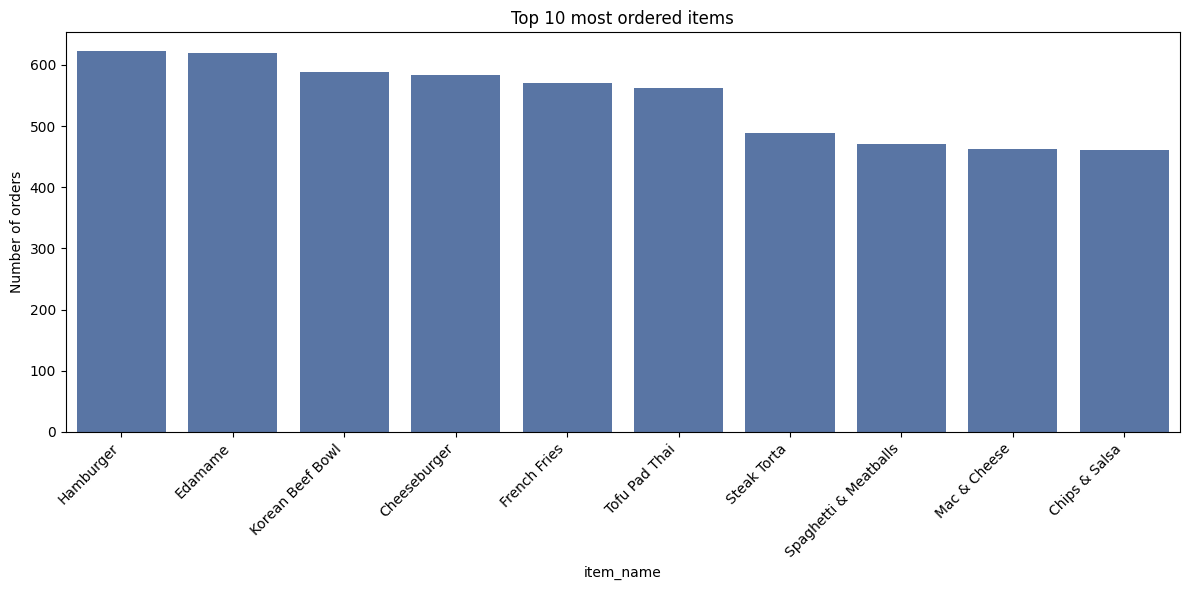

In [18]:
# Visualisation des articles les plus commandés
plt.figure(figsize=(12, 6))
sns.barplot(x=item_counts.head(10).index, y=item_counts.head(10).values)
plt.title('Top 10 des articles les plus commandés')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Nombre de commandes')
plt.tight_layout()
plt.show()


## **Analyse des catégories**

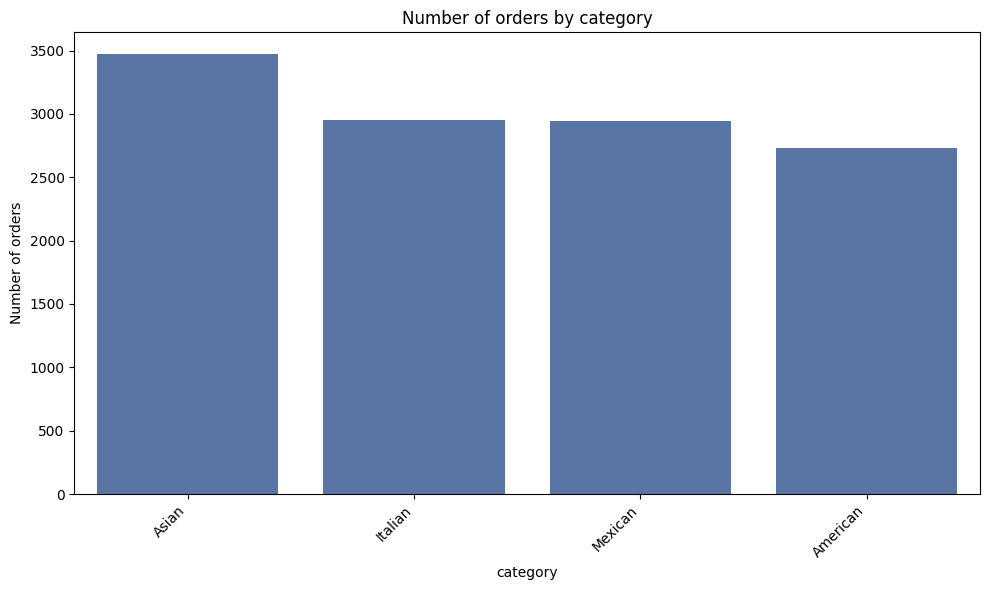

In [19]:
category_counts = orders_with_details['category'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.title('Nombre de commandes par catégorie')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Nombre de commandes')
plt.tight_layout()
plt.show()

In [20]:
# Calculer le chiffre d'affaires par catégorie
category_revenue = orders_with_details.groupby('category')['price'].sum().sort_values(ascending=False)
print("\nChiffre d'affaires par catégorie :")
print(category_revenue)


Chiffre d'affaires par catégorie :
category
Italian     49462.70
Asian       46720.65
Mexican     34796.80
American    28237.75
Name: price, dtype: float64


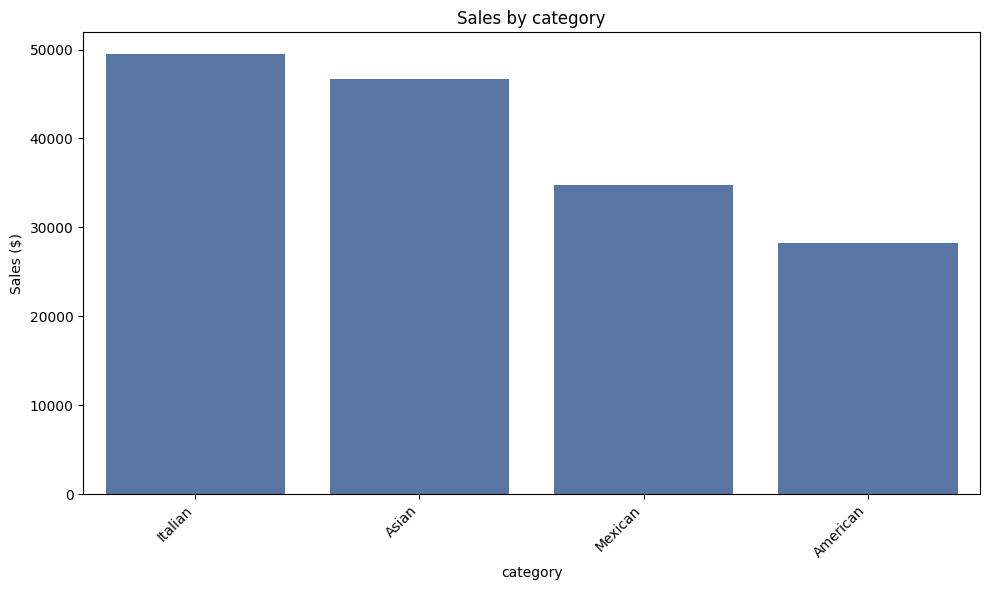

In [21]:
# Visualiser le chiffre d'affaires par catégorie
plt.figure(figsize=(10, 6))
sns.barplot(x=category_revenue.index, y=category_revenue.values)
plt.title("Chiffre d'affaires par catégorie")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Chiffre d\'affaires ($)')
plt.tight_layout()
plt.show()

### **Analyse temporelle des commandes**

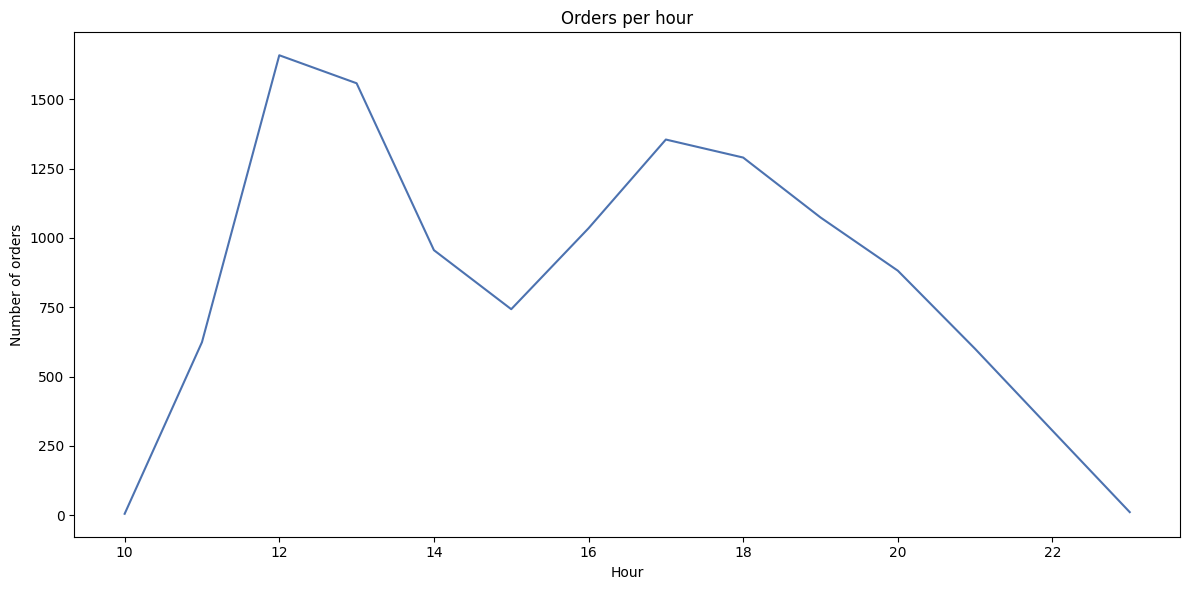

In [22]:
# Tendances horaires
hourly_orders = orders_with_details['hour'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_orders.index, y=hourly_orders.values)
plt.title('Nombre de commandes par heure')
plt.xlabel('Heure')
plt.ylabel('Nombre de commandes')
plt.tight_layout()
plt.show()


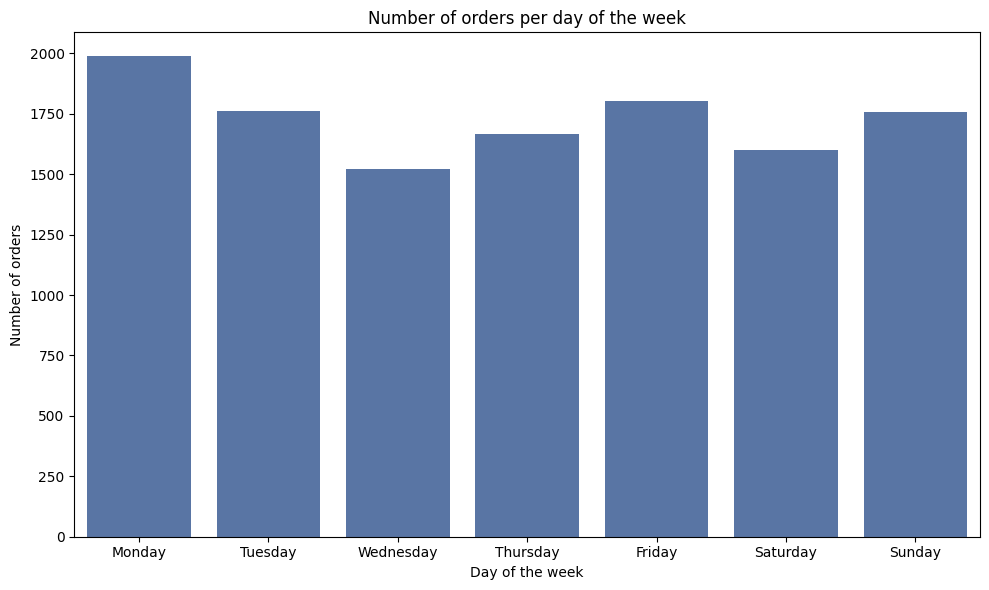

In [23]:
# Tendances journalières
daily_orders = orders_with_details['day_of_week'].value_counts().sort_index()
days = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
plt.figure(figsize=(10, 6))
sns.barplot(x=days, y=daily_orders.values)
plt.title('Nombre de commandes par jour de la semaine')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de commandes')
plt.tight_layout()
plt.show()

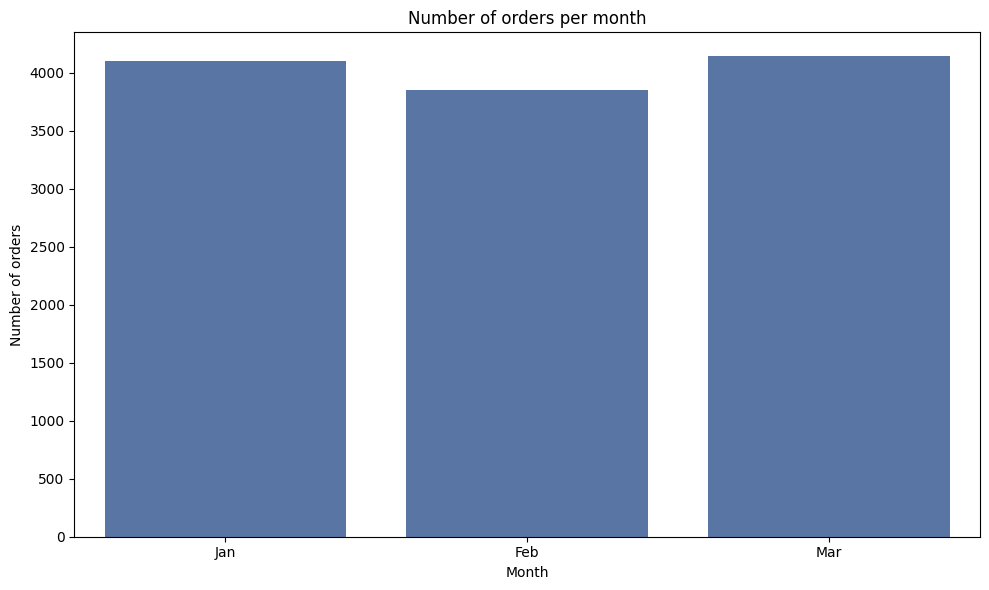

In [24]:
# Tendances mensuelles
monthly_orders = orders_with_details['month'].value_counts().sort_index()
months = ['Jan', 'Feb', 'Mar'] # Nous n'avons que ces trois dans les données
plt.figure(figsize=(10, 6))
sns.barplot(x=months, y=monthly_orders.values)
plt.title('Number of orders per month')
plt.xlabel('Month')
plt.ylabel('Number of orders')
plt.tight_layout()
plt.show()

### **Analyse des prix**

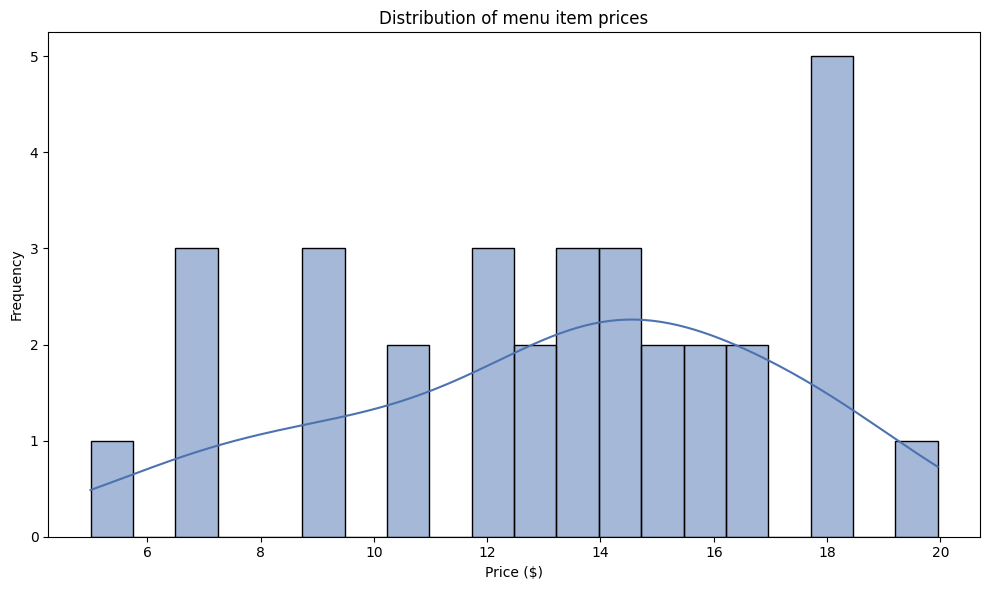

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(menu_items['price'], bins=20, kde=True)
plt.title('Distribution des prix des articles du menu')
plt.xlabel('Prix ($)')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

In [26]:
# Calculer le prix moyen par catégorie
avg_price_by_category = menu_items.groupby('category')['price'].mean().sort_values(ascending=False)
print("\nPrix moyen par catégorie :")
print(avg_price_by_category)


Prix moyen par catégorie :
category
Italian     16.750000
Asian       13.475000
Mexican     11.800000
American    10.066667
Name: price, dtype: float64


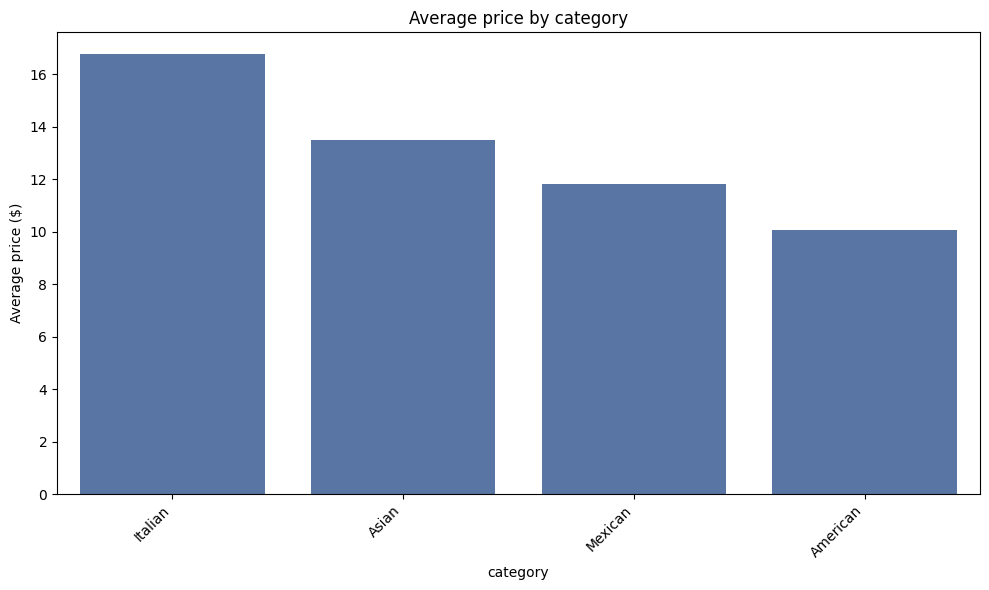

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_by_category.index, y=avg_price_by_category.values)
plt.title('Average price by category')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average price ($)')
plt.tight_layout()
plt.show()

## **Analyse des corrélations**

In [28]:
# Créer un DataFrame avec le nombre de commandes et le prix moyen par article
item_analysis = orders_with_details.groupby('item_name').agg({
    'order_id': 'count',
    'price': 'mean'
}).rename(columns={'order_id': 'order_count'})

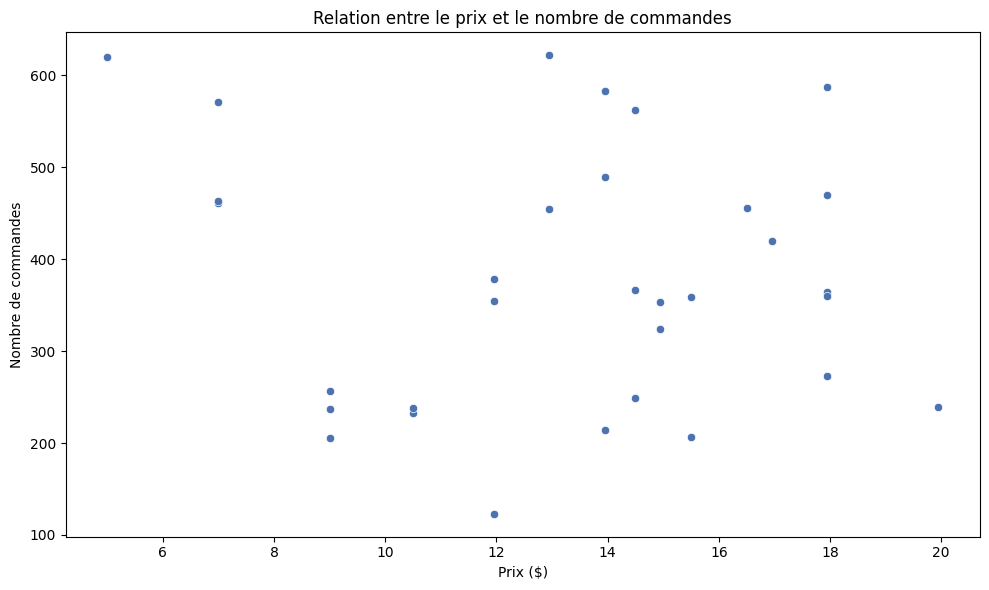

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=item_analysis, x='price', y='order_count')
plt.title('Relation entre le prix et le nombre de commandes')
plt.xlabel('Prix ($)')
plt.ylabel('Nombre de commandes')
plt.tight_layout()
plt.show()

In [30]:
# Calculer la corrélation
correlation = item_analysis['price'].corr(item_analysis['order_count'])
print(f"\nCorrélation entre le prix et le nombre de commandes : {correlation:.2f}")


Corrélation entre le prix et le nombre de commandes : -0.09


### **Analyse des commandes à haute valeur**

In [31]:
# Calcul du total de chaque commande
order_totals = orders_with_details.groupby('order_id')['price'].sum().sort_values(ascending=False)

print("\nTop 5 des commandes les plus chères :")
order_totals.head()


Top 5 des commandes les plus chères :


order_id
440     192.15
2075    191.05
1957    190.10
330     189.70
2675    185.10
Name: price, dtype: float64

In [32]:
# Détails des commandes les plus chères
top_orders = orders_with_details[orders_with_details['order_id'].isin(order_totals.head().index)]
print("\nDétails des articles dans les commandes les plus chères :")
print(top_orders.groupby(['order_id', 'item_name'])['price'].sum().sort_values(ascending=False))


Détails des articles dans les commandes les plus chères :
order_id  item_name            
1957      Chicken Parmesan         35.90
440       Spaghetti & Meatballs    35.90
2075      Eggplant Parmesan        33.90
1957      Eggplant Parmesan        33.90
2675      Eggplant Parmesan        33.90
1957      Steak Burrito            29.90
440       Fettuccine Alfredo       29.00
330       Tofu Pad Thai            29.00
2675      Chicken Burrito          25.90
440       Chicken Parmesan         17.95
          Korean Beef Bowl         17.95
          Meat Lasagna             17.95
330       Chicken Parmesan         17.95
2075      Spaghetti & Meatballs    17.95
          Meat Lasagna             17.95
330       Korean Beef Bowl         17.95
          Spaghetti & Meatballs    17.95
440       Eggplant Parmesan        16.95
1957      Orange Chicken           16.50
2075      Orange Chicken           16.50
330       Orange Chicken           16.50
2075      Mushroom Ravioli         15.50
2675   

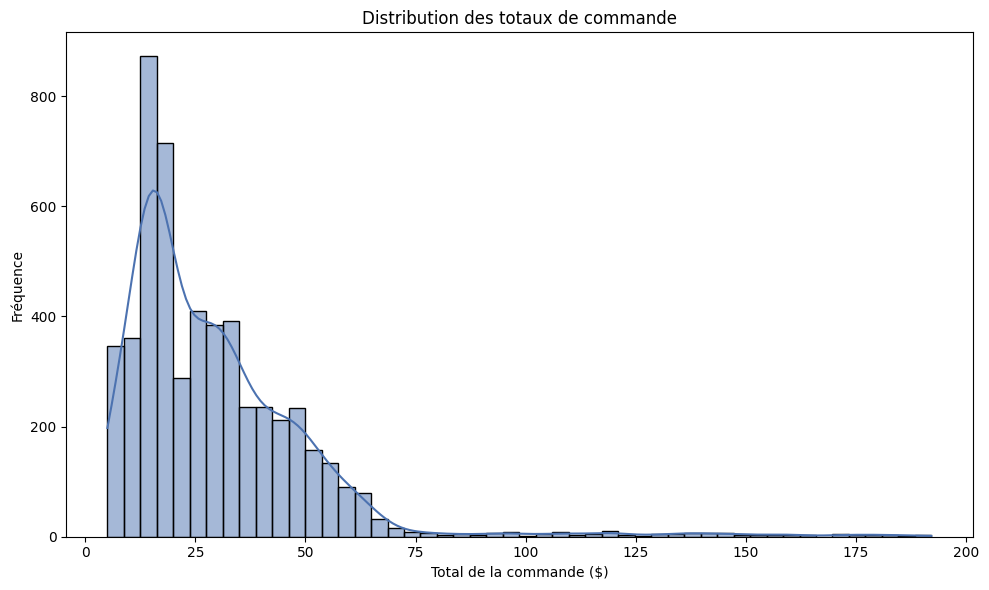

In [33]:
# Visualisation de la distribution des totaux de commande
plt.figure(figsize=(10, 6))
sns.histplot(order_totals, bins=50, kde=True)
plt.title('Distribution des totaux de commande')
plt.xlabel('Total de la commande ($)')
plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

In [34]:
# Analyse des caractéristiques des commandes à haute valeur
high_value_orders = orders_with_details[orders_with_details['order_id'].isin(order_totals.head(50).index)]

print("\nCatégories les plus fréquentes dans les commandes à haute valeur :")
print(high_value_orders['category'].value_counts(normalize=True))


Catégories les plus fréquentes dans les commandes à haute valeur :
category
Italian     0.270181
Asian       0.260297
Mexican     0.248764
American    0.220758
Name: proportion, dtype: float64


In [35]:
print("\nMoment de la journée pour les commandes à haute valeur :")
print(high_value_orders['hour'].value_counts(normalize=True).sort_index())


Moment de la journée pour les commandes à haute valeur :
hour
11    0.064250
12    0.431631
13    0.360791
14    0.143328
Name: proportion, dtype: float64


### **Analyse de rentabilité par catégorie**

In [36]:
category_profit = orders_with_details.groupby('category').agg({
    'price': 'sum',
    'order_id': 'count'
}).rename(columns={'price': 'total_revenue', 'order_id': 'order_count'})

category_profit['average_order_value'] = category_profit['total_revenue'] / category_profit['order_count']
category_profit = category_profit.sort_values('total_revenue', ascending=False)

print(category_profit)

          total_revenue  order_count  average_order_value
category                                                 
Italian        49462.70         2948            16.778392
Asian          46720.65         3470            13.464164
Mexican        34796.80         2945            11.815552
American       28237.75         2734            10.328365


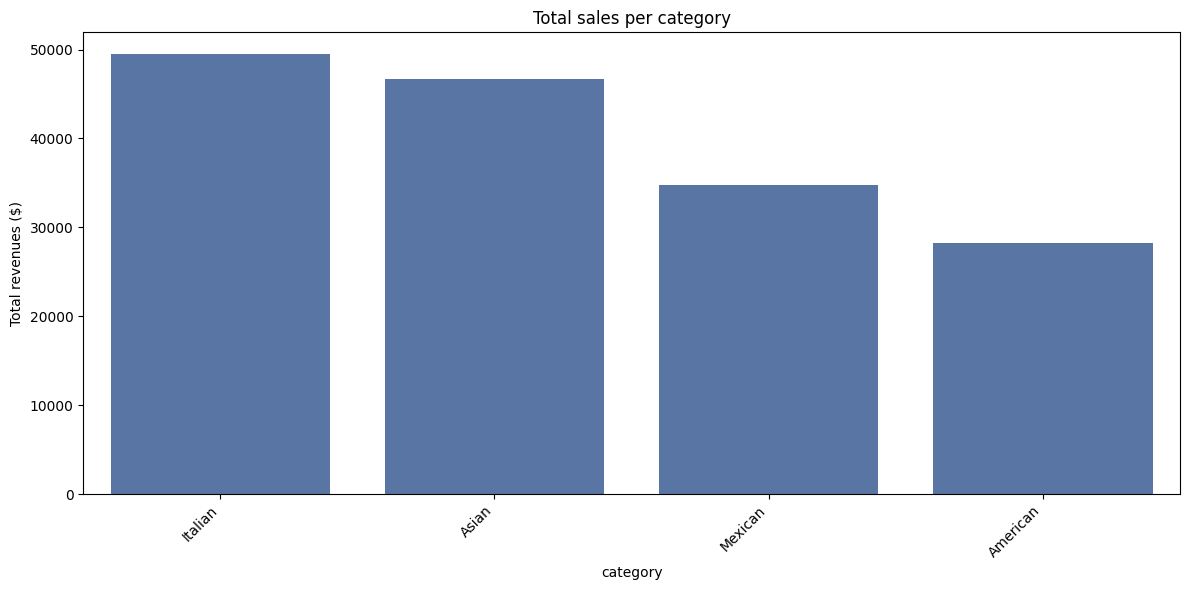

In [59]:
# Visualisation de la rentabilité par catégorie
plt.figure(figsize=(12, 6))
sns.barplot(x=category_profit.index, y=category_profit['total_revenue'])
plt.title('Chiffre d\'affaires total par catégorie')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Chiffre d\'affaires total ($)')
plt.tight_layout()
plt.show()

### **Analyse prédictive simple**

In [38]:
orders_with_details.groupby([orders_with_details['order_datetime'].dt.date, orders_with_details['order_datetime'].dt.hour]).size()

order_datetime  order_datetime
2023-01-01      11                 6
                12                17
                13                32
                14                15
                15                14
                                  ..
2023-03-31      18                15
                19                11
                20                11
                21                 9
                22                 5
Length: 1047, dtype: int64

In [39]:
# Préparation des données pour la prédiction du nombre de commandes par heure
hourly_data = orders_with_details.groupby([orders_with_details['order_datetime'].dt.date, orders_with_details['order_datetime'].dt.hour]).size()
hourly_data.index.names = ['date', 'hour']  # Renomme les index avant le reset_index
hourly_data = hourly_data.reset_index(name='order_count')

hourly_data['day_of_week'] = pd.to_datetime(hourly_data['date']).dt.dayofweek
hourly_data['month'] = pd.to_datetime(hourly_data['date']).dt.month

In [40]:
X = hourly_data[['hour', 'day_of_week', 'month']]
y = hourly_data['order_count']

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [42]:
print("Performances du modèle de prédiction :")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Performances du modèle de prédiction :
RMSE: 7.53
R2 Score: 0.05


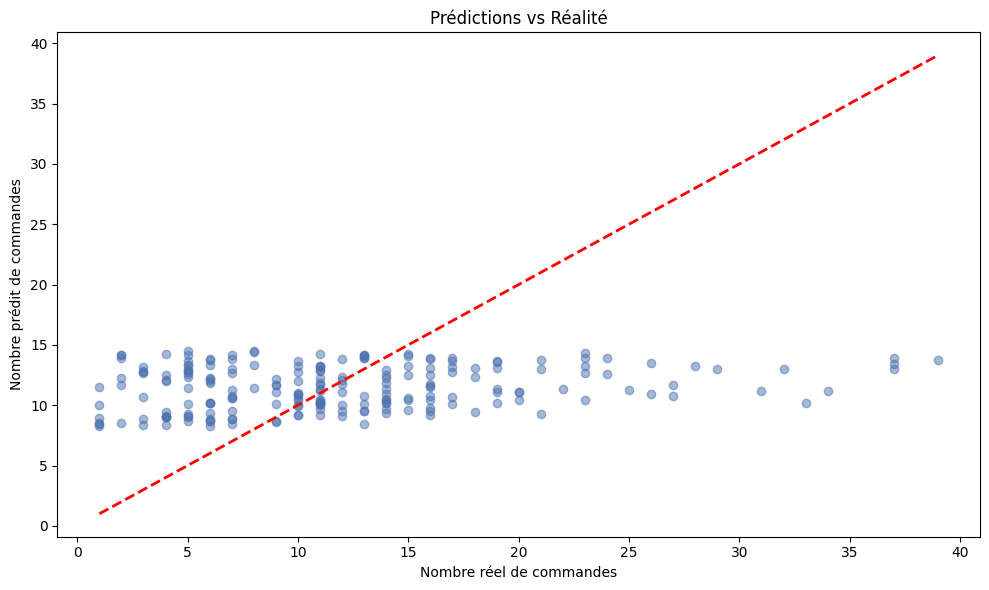

In [43]:
# Visualisation des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nombre réel de commandes')
plt.ylabel('Nombre prédit de commandes')
plt.title('Prédictions vs Réalité')
plt.tight_layout()
plt.show()

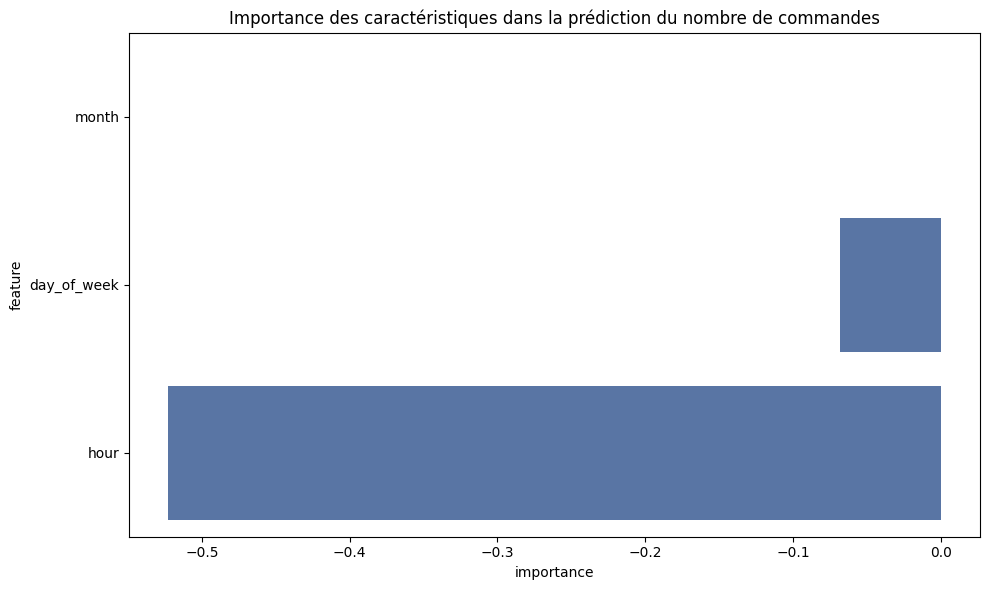

In [44]:
# Importance des caractéristiques
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.coef_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Importance des caractéristiques dans la prédiction du nombre de commandes')
plt.tight_layout()
plt.show()

### **Modèle prédictif amélioré**

In [45]:
# Préparation des données
hourly_data = orders_with_details.groupby([orders_with_details['order_datetime'].dt.date, orders_with_details['order_datetime'].dt.hour]).size()
hourly_data.index.names = ['date', 'hour']
hourly_data = hourly_data.reset_index(name='order_count')

In [46]:
# Feature engineering
hourly_data['day_of_week'] = pd.to_datetime(hourly_data['date']).dt.dayofweek
hourly_data['month'] = pd.to_datetime(hourly_data['date']).dt.month
hourly_data['is_weekend'] = hourly_data['day_of_week'].isin([5, 6]).astype(int)
hourly_data['is_meal_time'] = hourly_data['hour'].isin([7, 8, 12, 13, 18, 19, 20]).astype(int)


In [47]:
# Encodage one-hot pour les variables catégorielles
ct = ColumnTransformer([
    ('encoder', OneHotEncoder(drop='first', sparse_output=False), ['day_of_week', 'month'])
], remainder='passthrough')

X = hourly_data[['day_of_week', 'month', 'hour', 'is_weekend', 'is_meal_time']]
y = hourly_data['order_count']

In [48]:
X = hourly_data[['day_of_week', 'month', 'hour', 'is_weekend', 'is_meal_time']]
y = hourly_data['order_count']

X_encoded = ct.fit_transform(X)
feature_names = (ct.named_transformers_['encoder'].get_feature_names_out(['day_of_week', 'month']).tolist() + 
                 ['hour', 'is_weekend', 'is_meal_time'])

In [49]:
# Split des données
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Entraînement du modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédictions et évaluation
y_pred = rf_model.predict(X_test)

print("Performances du modèle Random Forest :")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

Performances du modèle Random Forest :
RMSE: 7.77
R2 Score: -0.01


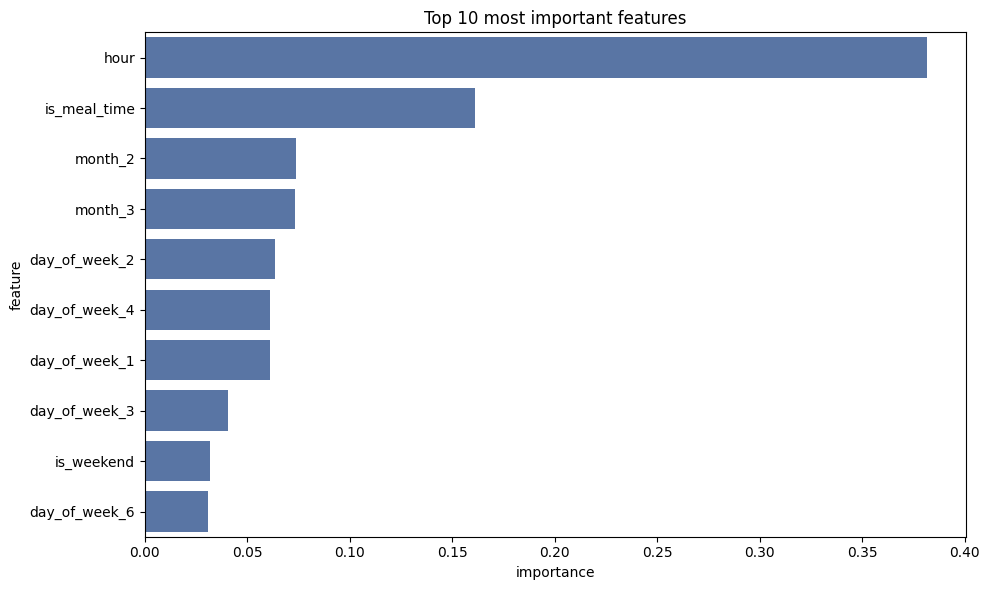

In [50]:
# Importance des caractéristiques
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 des caractéristiques les plus importantes')
plt.tight_layout()
plt.show()

- Heure (`hour`) : C'est de loin la caractéristique la plus importante, ce qui est logique pour un restaurant. Cela suggère que le moment de la journée est le facteur le plus déterminant pour prédire le nombre de commandes.
- Heure de repas (`is_meal_time`) : La deuxième caractéristique la plus importante, ce qui confirme que les heures de repas traditionnelles ont un impact significatif sur le nombre de commandes.
- Mois (`month_2` et `month_3`) : Les mois semblent avoir une certaine importance, avec février (`month_2`) et mars (`month_3`) apparaissant dans le top 5. Cela pourrait indiquer des variations saisonnières dans les habitudes de commande.
- Jours de la semaine : Plusieurs jours de la semaine apparaissent dans le top 10, indiquant que certains jours sont plus occupés que d'autres.
- Est weekend (`is_weekend`) : Cette caractéristique apparaît dans le top 10, mais avec une importance relativement faible, ce qui est un peu surprenant.

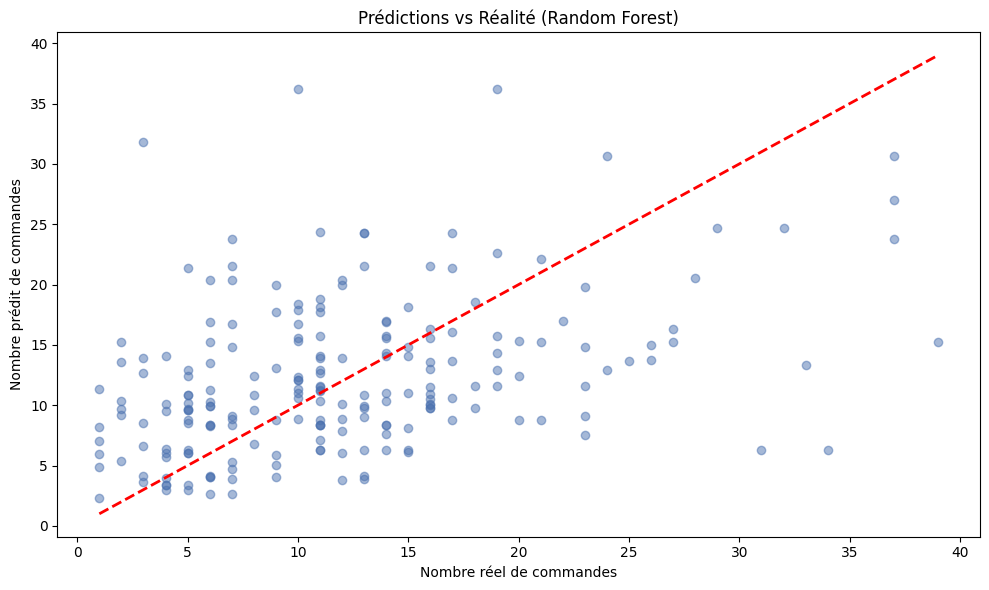

In [51]:
# Comparaison des prédictions vs réalité
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Nombre réel de commandes')
plt.ylabel('Nombre prédit de commandes')
plt.title('Prédictions vs Réalité (Random Forest)')
plt.tight_layout()
plt.show()

 #### **Analyse détaillée de la relation heure-commandes**

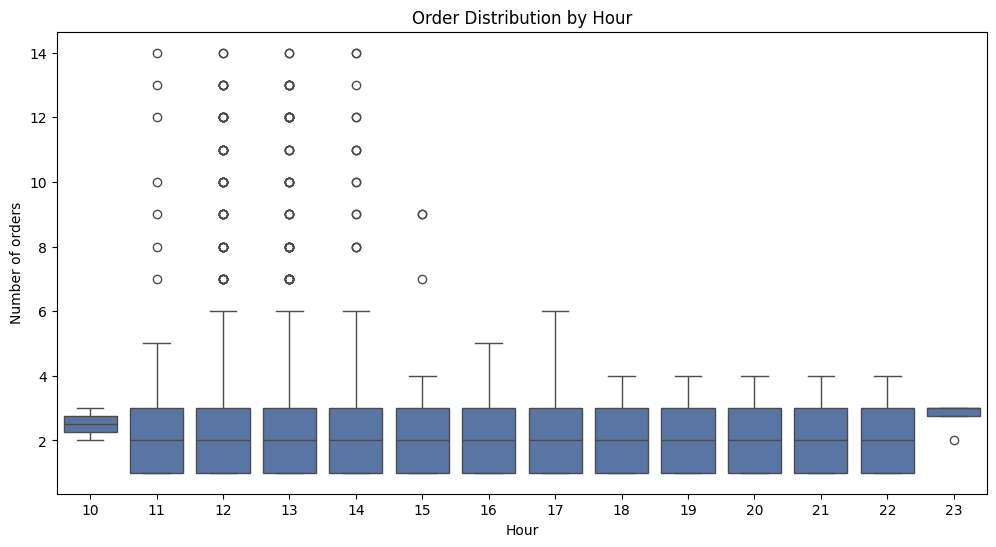

In [58]:
# Agrégation des données par heure
hourly_orders = orders_with_details.groupby('order_datetime').size().reset_index(name='order_count')
hourly_orders['hour'] = hourly_orders['order_datetime'].dt.hour

# Visualisation de la distribution des commandes par heure
plt.figure(figsize=(12, 6))
sns.boxplot(x='hour', y='order_count', data=hourly_orders)
plt.title('Distribution des commandes par heure')
plt.xlabel('Heure')
plt.ylabel('Nombre de commandes')
plt.show()

- On observe une grande variabilité dans le nombre de commandes pour chaque heure.
- Les heures de midi (**11h-14h**) semblent avoir la plus grande variabilité et potentiellement le plus grand nombre de commandes.
- Il y a des valeurs aberrantes (outliers) pour presque toutes les heures, indiquant des périodes de pointe occasionnelles.

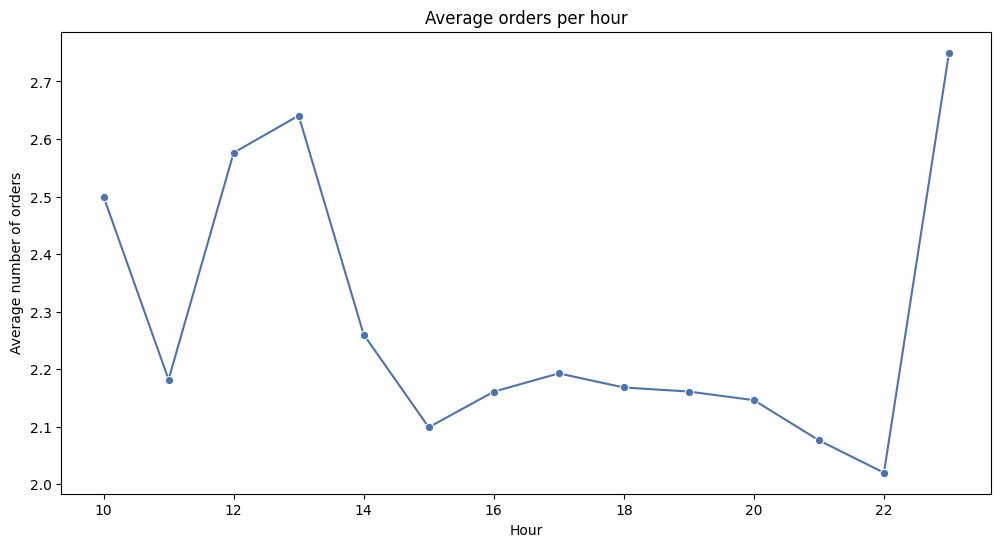

In [53]:
# Moyenne des commandes par heure
avg_orders_by_hour = hourly_orders.groupby('hour')['order_count'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='order_count', data=avg_orders_by_hour, marker='o')
plt.title('Moyenne des commandes par heure')
plt.xlabel('Heure')
plt.ylabel('Nombre moyen de commandes')
plt.show()

- On voit clairement deux pics : un autour de 13h (probablement le déjeuner) et un plus important à 23h.
- Le creux le plus bas est vers 15h-16h, ce qui est logique entre le déjeuner et le dîner.

#### **Analyse de séries temporelles**

<Figure size 1200x1000 with 0 Axes>

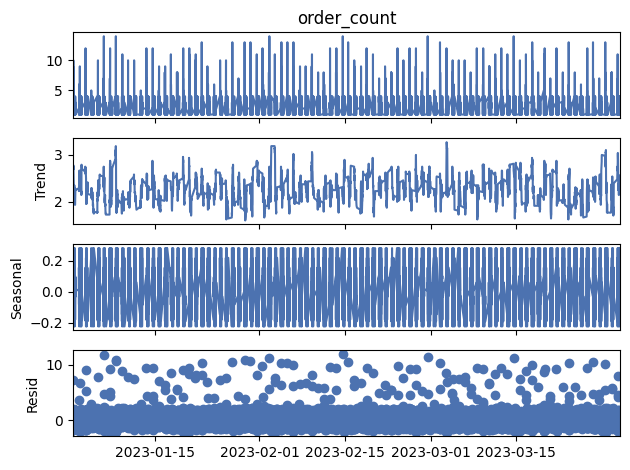

In [54]:
# Préparation des données pour l'analyse de séries temporelles
ts_data = hourly_orders.set_index('order_datetime')['order_count']

# Décomposition de la série temporelle
decomposition = seasonal_decompose(ts_data, model='additive', period=24)
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

- La tendance montre de légères variations sur la période, mais reste relativement stable.
- La composante saisonnière est très claire, montrant un pattern qui se répète probablement quotidiennement.
- Les résidus semblent avoir une variance constante, ce qui est bon pour la modélisation.

In [55]:
# Modèle ARIMA simple
# Nous utiliserons les dernières 168 heures (1 semaine) comme ensemble de test
train = ts_data[:-168]
test = ts_data[-168:]

# Fit du modèle ARIMA
model = ARIMA(train, order=(1, 1, 1))  # Les paramètres (p,d,q) peuvent être ajustés
fitted_model = model.fit()

c:\Users\DIALO\Desktop\Github projects\Gestion restau\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DIALO\Desktop\Github projects\Gestion restau\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\DIALO\Desktop\Github projects\Gestion restau\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [56]:
# Prévisions
forecast = fitted_model.forecast(steps=168)

# Évaluation du modèle
mse = mean_squared_error(test, forecast)
rmse = np.sqrt(mse)
print(f"RMSE du modèle ARIMA : {rmse:.2f}")

RMSE du modèle ARIMA : 1.50


c:\Users\DIALO\Desktop\Github projects\Gestion restau\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\DIALO\Desktop\Github projects\Gestion restau\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


- Cette valeur indique que, en moyenne, les prédictions du modèle s'écartent de 1.5 commandes par rapport aux valeurs réelles.
- Étant donné que le nombre moyen de commandes par heure varie entre 2 et 3, cette erreur est assez significative.

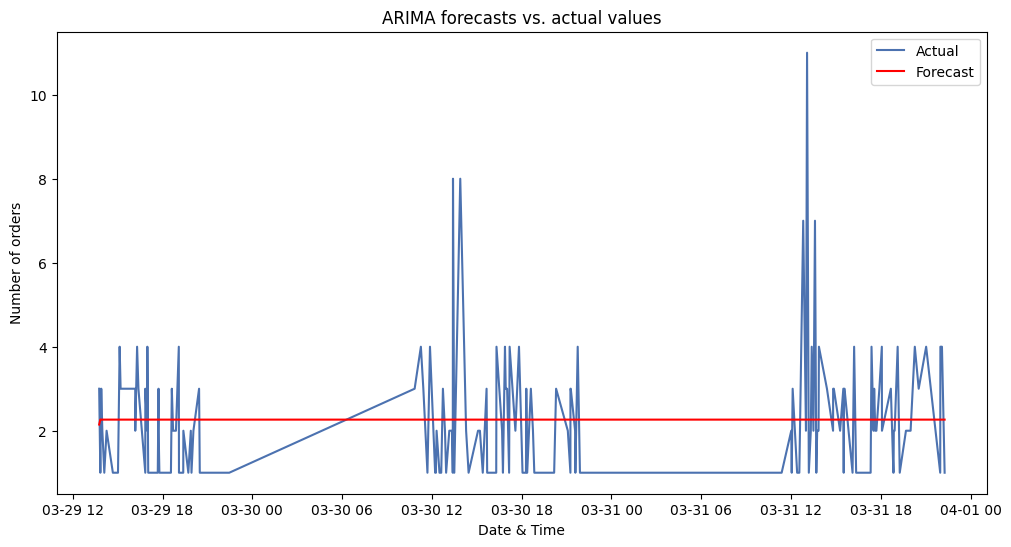

In [57]:
# Visualisation des prévisions
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Real')
plt.plot(test.index, forecast, color='red', label='Prévisions')
plt.title('Prévisions ARIMA vs Valeurs Réelles')
plt.xlabel('Date et Heure')
plt.ylabel('Nombre de commandes')
plt.legend()
plt.show()

- Le modèle ARIMA semble avoir du mal à capturer la volatilité des données réelles.
- Les prévisions apparaissent comme une ligne presque droite, ne capturant pas les pics et les creux des données réelles.